In [1]:
import pandas as pd, numpy as np, json, joblib, time
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix)

# -----------------------------------------------------------
TRAIN_CSV = Path("train_10s_window.csv")
HOLD_CSV  = Path("holdout_10s_window.csv")
LABELS    = ["valence", "arousal"]       

train_df = pd.read_csv(TRAIN_CSV)
hold_df  = pd.read_csv(HOLD_CSV)

FEATURE_COLS = [c for c in train_df.columns if c not in (
    "subject", "trial", "window",
    "valence", "arousal",
    "valence_label", "arousal_label")]

# common pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn",    KNeighborsClassifier())
])

param_grid = {
    "knn__n_neighbors": [3, 5, 7],
    "knn__weights":     ["uniform", "distance"],
    "knn__metric":      ["euclidean", "manhattan"]
}

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

all_cv, holdouts, best_models = {}, {}, {}

for label in LABELS:
    y_train = train_df[f"{label}_label"].values
    y_hold  = hold_df [f"{label}_label"].values
    X_train = train_df[FEATURE_COLS]
    X_hold  = hold_df [FEATURE_COLS]

    cv_folds, best_f1, best_model = [], 0, None
    print(f"\n [{label.upper()}] Nested CV – KNN 10sec window\n")
    t0 = time.time()

    for i, (tr_idx, val_idx) in enumerate(outer_cv.split(X_train, y_train), 1):
        grid = GridSearchCV(
            pipe, param_grid, scoring="f1", cv=inner_cv,
            n_jobs=-1, verbose=0
        )
        grid.fit(X_train.iloc[tr_idx], y_train[tr_idx])
        y_pred = grid.best_estimator_.predict(X_train.iloc[val_idx])

        acc = accuracy_score(y_train[val_idx], y_pred)
        f1  = f1_score(y_train[val_idx], y_pred, zero_division=0)

        cv_folds.append({
            "fold": i,
            "best_params": grid.best_params_,
            "accuracy": acc,
            "precision": precision_score(y_train[val_idx], y_pred, zero_division=0),
            "recall": recall_score(y_train[val_idx], y_pred, zero_division=0),
            "f1_score": f1,
            "confusion_matrix": confusion_matrix(y_train[val_idx], y_pred).tolist()
        })
        print(f"[{label.upper()}] Fold {i}/5 | Acc={acc:.3f}  F1={f1:.3f}  "
              f"n={grid.best_params_['knn__n_neighbors']}, "
              f"w={grid.best_params_['knn__weights'][0]}, "
              f"metric={grid.best_params_['knn__metric']}")

        if f1 > best_f1:
            best_f1, best_model = f1, grid.best_estimator_

    print(f" [{label.upper()}] CV done in {time.time()-t0:.1f}s | Best F1={best_f1:.3f}")

    # ----- hold-out evaluation -----
    y_hold_pred = best_model.predict(X_hold)
    hold_metrics = {
        "accuracy":  accuracy_score(y_hold, y_hold_pred),
        "precision": precision_score(y_hold, y_hold_pred, zero_division=0),
        "recall":    recall_score(y_hold, y_hold_pred, zero_division=0),
        "f1_score":  f1_score(y_hold, y_hold_pred, zero_division=0),
        "confusion_matrix": confusion_matrix(y_hold, y_hold_pred).tolist()
    }
    print(f" [{label.upper()}] Hold-out → Acc={hold_metrics['accuracy']:.3f}, "
          f"F1={hold_metrics['f1_score']:.3f}\n")

    all_cv[label]   = cv_folds
    holdouts[label] = hold_metrics
    best_models[label] = best_model
    joblib.dump(best_model, f"best_{label}_knn_10s_window.joblib")

# ---------- pairwise accuracy on hold-out ----------
true_pairs = list(zip(hold_df["valence_label"], hold_df["arousal_label"]))
pred_pairs = list(zip(
    best_models["valence"].predict(hold_df[FEATURE_COLS]),
    best_models["arousal"].predict(hold_df[FEATURE_COLS])
))
pair_acc = sum(int(t == p) for t, p in zip(true_pairs, pred_pairs)) / len(true_pairs)

# ---------- save JSON report -----------------------
report = {
    "cv_folds": all_cv,
    "holdout":  holdouts,
    "pairwise_accuracy": pair_acc
}
with open("knn_grid_results_10s_window.json", "w", encoding="utf-8") as fp:
    json.dump(report, fp, indent=4)

print(f" Pairwise accuracy on hold-out = {pair_acc:.3f}")
print("  All metrics saved → knn_grid_results_10s_window.json")



 [VALENCE] Nested CV – KNN 10sec window

[VALENCE] Fold 1/5 | Acc=0.754  F1=0.803  n=3, w=d, metric=manhattan
[VALENCE] Fold 2/5 | Acc=0.761  F1=0.803  n=3, w=d, metric=manhattan
[VALENCE] Fold 3/5 | Acc=0.765  F1=0.809  n=3, w=d, metric=manhattan
[VALENCE] Fold 4/5 | Acc=0.801  F1=0.837  n=3, w=d, metric=manhattan
[VALENCE] Fold 5/5 | Acc=0.730  F1=0.776  n=3, w=d, metric=manhattan
 [VALENCE] CV done in 7.4s | Best F1=0.837
 [VALENCE] Hold-out → Acc=0.732, F1=0.779


 [AROUSAL] Nested CV – KNN 10sec window

[AROUSAL] Fold 1/5 | Acc=0.742  F1=0.689  n=3, w=d, metric=manhattan
[AROUSAL] Fold 2/5 | Acc=0.777  F1=0.743  n=3, w=d, metric=manhattan
[AROUSAL] Fold 3/5 | Acc=0.746  F1=0.715  n=3, w=d, metric=manhattan
[AROUSAL] Fold 4/5 | Acc=0.789  F1=0.759  n=3, w=d, metric=manhattan
[AROUSAL] Fold 5/5 | Acc=0.775  F1=0.741  n=3, w=d, metric=manhattan
 [AROUSAL] CV done in 7.3s | Best F1=0.759
 [AROUSAL] Hold-out → Acc=0.743, F1=0.724

 Pairwise accuracy on hold-out = 0.571
  All metrics s

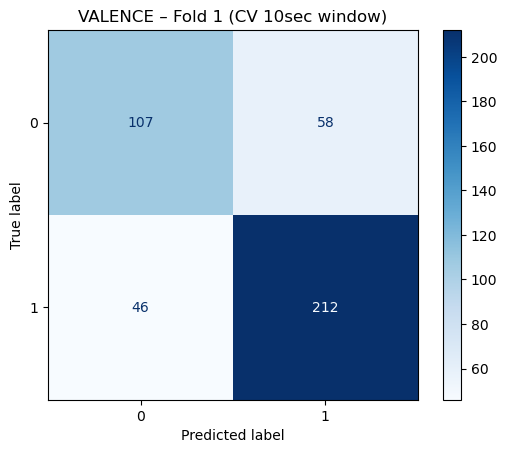

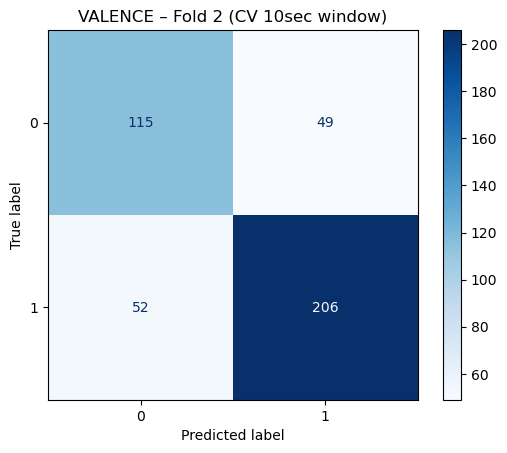

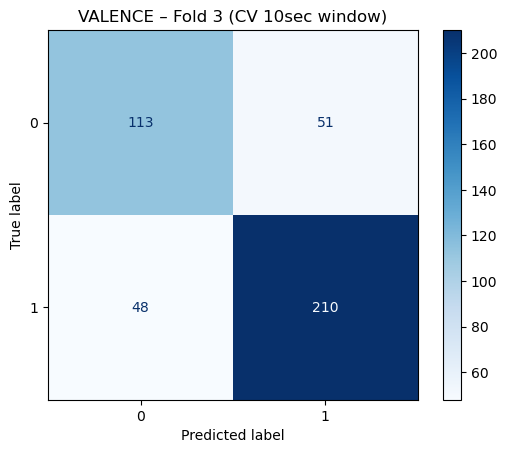

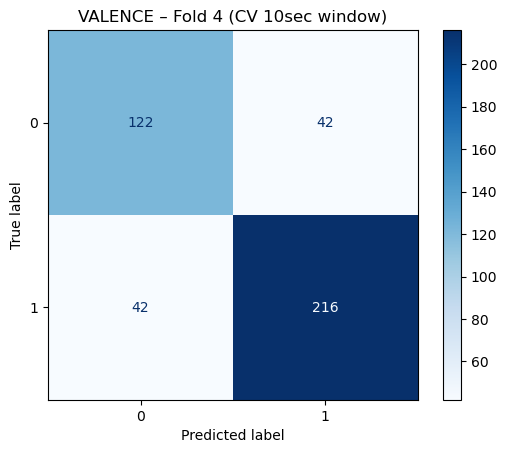

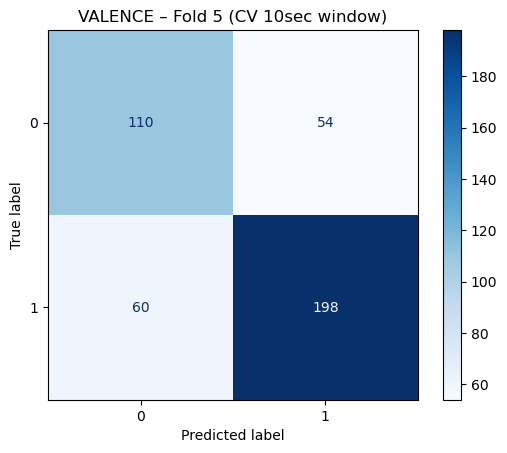

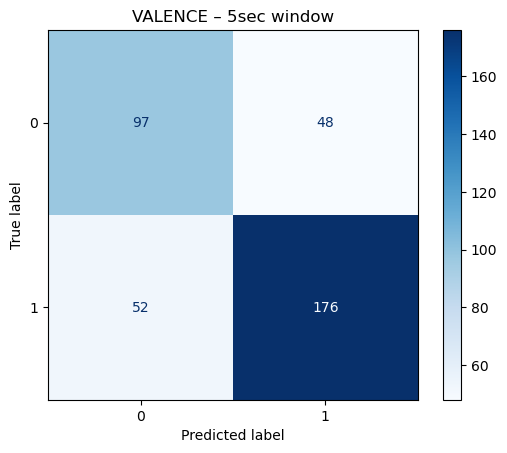

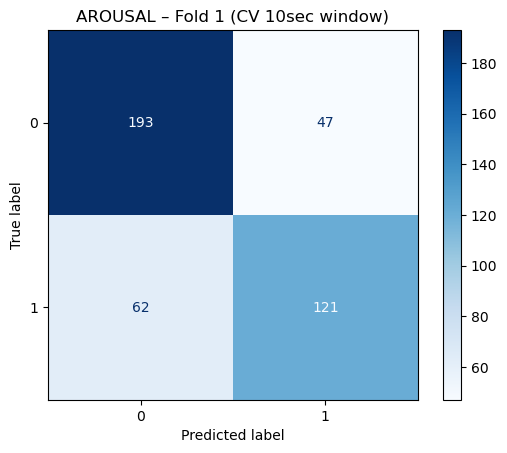

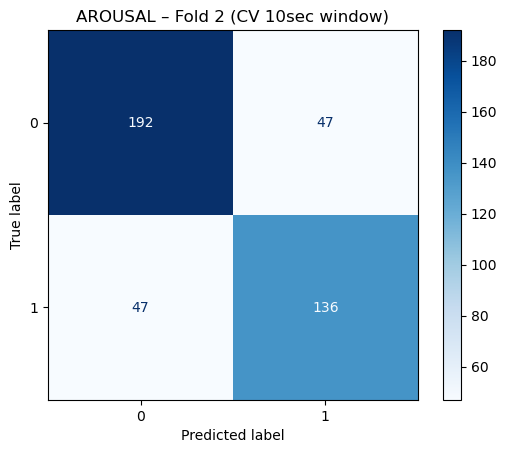

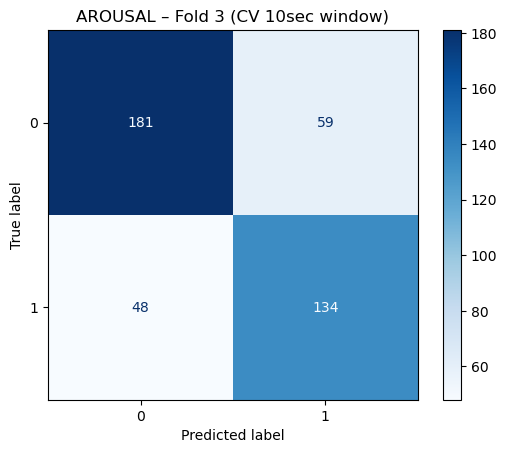

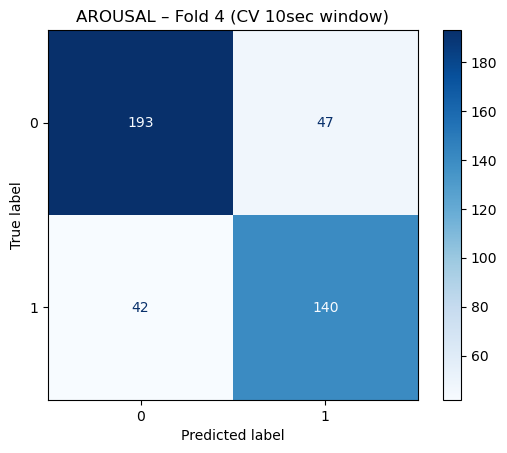

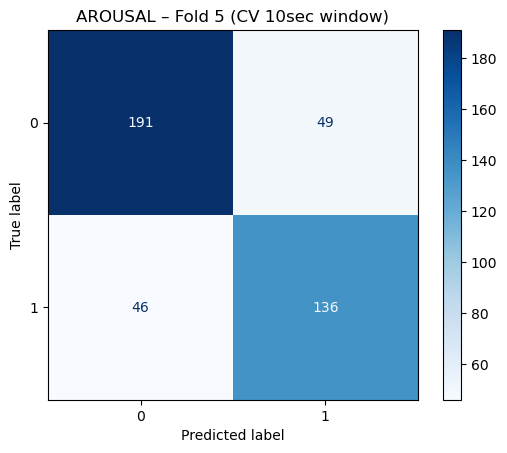

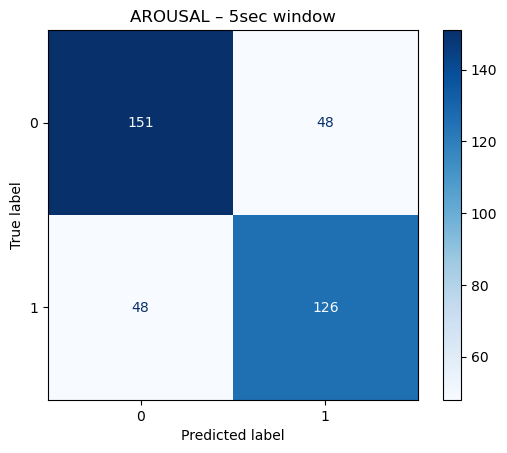

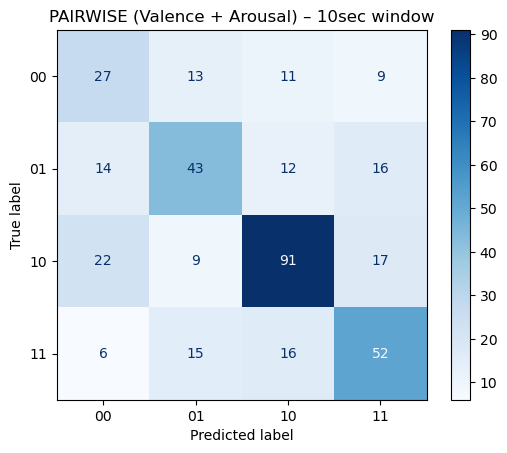

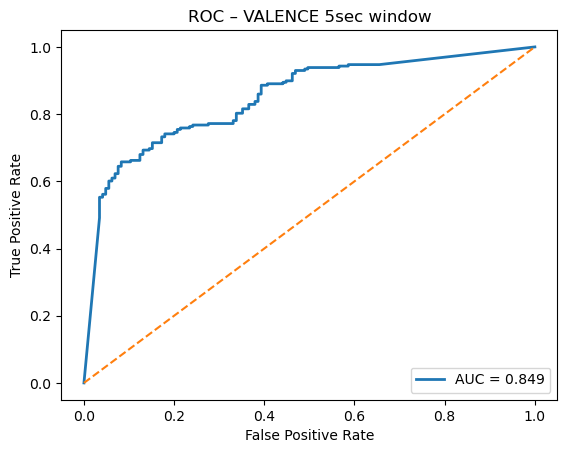

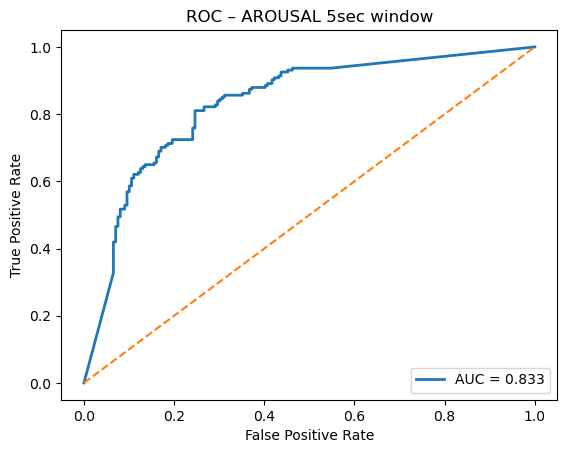

In [2]:
# ==========================================================
# plot_knn_confmat_roc.py  –  visualisation for KNN models
# ==========================================================
import json, joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc)

# ---------- file paths ----------
RESULTS_JSON = Path("knn_grid_results_10s_window.json")
VAL_MODEL    = Path("best_valence_knn_10s_window.joblib")
ARO_MODEL    = Path("best_arousal_knn_10s_window.joblib")
HOLD_CSV     = Path("holdout_10s_window.csv")

# ---------- load results ----------
with RESULTS_JSON.open() as fp:
    res = json.load(fp)

hold_df = pd.read_csv(HOLD_CSV)
X_hold  = hold_df[[c for c in hold_df.columns if c not in (
    "subject","trial","window",
    "valence","arousal",
    "valence_label","arousal_label")]]

# ---------- helper: confusion-matrix plot ----------
def plot_cm(cm, title, labels=None):
    n_classes = cm.shape[0]
    if labels is None:
        labels = list(range(n_classes))
    fig, ax = plt.subplots()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels)
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)
    ax.set_title(title)
    plt.show()

# ---------- per-fold & hold-out confusion matrices ----------
for label, model_path in [("valence", VAL_MODEL), ("arousal", ARO_MODEL)]:
    # per-fold (from JSON)
    for fold in res["cv_folds"][label]:
        cm = np.array(fold["confusion_matrix"])
        plot_cm(cm, f"{label.upper()} – Fold {fold['fold']} (CV 10sec window)")
    # hold-out
    mdl = joblib.load(model_path)
    y_true = hold_df[f"{label}_label"].values
    y_pred = mdl.predict(X_hold)
    cm_hold = confusion_matrix(y_true, y_pred)
    plot_cm(cm_hold, f"{label.upper()} – 5sec window")

# ---------- pairwise confusion matrix ----------
pair_true = list(zip(hold_df["valence_label"], hold_df["arousal_label"]))
pair_pred = list(zip(
    joblib.load(VAL_MODEL).predict(X_hold),
    joblib.load(ARO_MODEL).predict(X_hold)
))
pair_map   = {(0,0):0, (0,1):1, (1,0):2, (1,1):3}
y_true_p   = [pair_map[t] for t in pair_true]
y_pred_p   = [pair_map[p] for p in pair_pred]
cm_pair    = confusion_matrix(y_true_p, y_pred_p)
pair_lbls  = ["00", "01", "10", "11"]
plot_cm(cm_pair, "PAIRWISE (Valence + Arousal) – 10sec window", labels=pair_lbls)

# ---------- ROC curves on hold-out ----------
def plot_roc(model, X, y, title):
    scores = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") \
             else model.kneighbors(X, return_distance=True)[0][:, 0] * -1
    fpr, tpr, _ = roc_curve(y, scores)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc(joblib.load(VAL_MODEL), X_hold,
         hold_df["valence_label"].values,
         "ROC – VALENCE 5sec window")
plot_roc(joblib.load(ARO_MODEL), X_hold,
         hold_df["arousal_label"].values,
         "ROC – AROUSAL 5sec window")


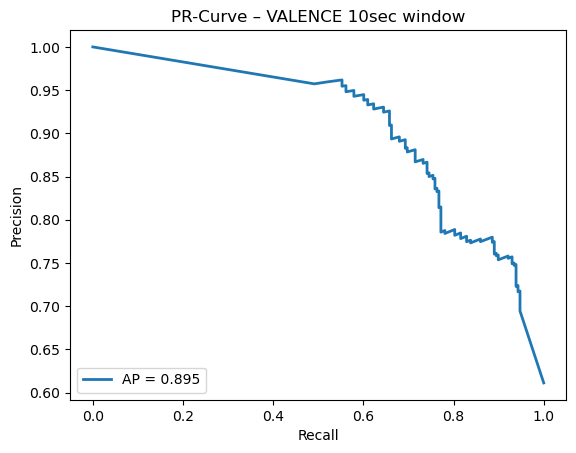

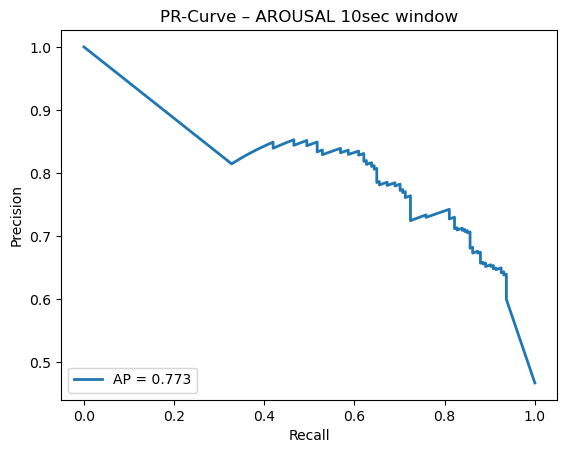

In [3]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# --- K-NN may or may not expose predict_proba; handle both cases ---
def _knn_scores(model, X):
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]          # works for weights='uniform'/'distance'
    # fallback: inverse distance of nearest neighbour (higher = “more positive”)
    return -model.kneighbors(X, return_distance=True)[0][:, 0]

def plot_pr(model, X, y, title):
    scores = _knn_scores(model, X)
    precision, recall, _ = precision_recall_curve(y, scores)
    pr_auc = average_precision_score(y, scores)
    plt.figure()
    plt.plot(recall, precision, lw=2, label=f"AP = {pr_auc:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend(loc="lower left")
    plt.show()

plot_pr(joblib.load(VAL_MODEL), X_hold,
        hold_df["valence_label"].values,
        "PR-Curve – VALENCE 10sec window")
plot_pr(joblib.load(ARO_MODEL), X_hold,
        hold_df["arousal_label"].values,
        "PR-Curve – AROUSAL 10sec window")
